<a href="https://colab.research.google.com/github/maggomor/adoption_project/blob/main/Animal_Adoption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assessing the likelihood of cats & dogs getting adopted

Whoever knows me, knows that I am an absolute animal lover, especially cats and dogs. Therefore, today I started looking into what kinds of factors may impact whether an animal in a shelter would get adopted.

I use the dataset kindly provided here: https://data.world/rdowns26/austin-animal-shelter 
It mainly utilises data from Austin Animal Shelters that is available online. I have provided it on my GitHub-Repository as well. Let's first import some basic packages as well as the data as used by the authors in the above project (and in their raw form).

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
df = pd.read_csv("https://raw.githubusercontent.com/maggomor/adoption_project/main/all_records.csv")

outcome_df = pd.read_csv("https://raw.githubusercontent.com/maggomor/adoption_project/main/Austin_Animal_Center_Outcomes.csv")

intake_df = pd.read_csv("https://raw.githubusercontent.com/maggomor/adoption_project/main/Austin_Animal_Center_Intakes.csv")
df.shape, outcome_df.shape, intake_df.shape


((76977, 38), (63643, 12), (63328, 12))

When I first checked this, I felt that something was wrong in the data as provided by the authors. Using a dataset of intakes and outcomes both below 70k, they rose above 70k observations? That sparked my interest. Observe for example the data for a cute little kitty named "Mustachala":

In [92]:
df[df["Name_intake"]=="Mustachala"]

,Unnamed: 0,Animal ID,Name_intake,DateTime_intake,MonthYear_intake,Found_Location,Intake_Type,IntakeCondition,Animal_Type_intake,Sex,...,beagle,terrier,boxer,poodle,rottweiler,dachshund,chihuahua,pit bull,DateTime_length,Days_length
5,5,A683798,Mustachala,2016-07-21 12:16:00,07/21/2016 12:16:00 PM,3118 Windsor Rd in Austin (TX),Stray,Normal,Cat,Spayed Female,...,0,0,0,0,0,0,0,0,88 days 22:39:00.000000000,12 weeks - 6 months
6,6,A683798,Mustachala,2016-07-21 12:16:00,07/21/2016 12:16:00 PM,3118 Windsor Rd in Austin (TX),Stray,Normal,Cat,Spayed Female,...,0,0,0,0,0,0,0,0,-729 days +05:50:00.000000000,NaN
7,7,A683798,Mustachala,2014-07-15 15:38:00,07/15/2014 03:38:00 PM,Austin (TX),Owner Surrender,Normal,Cat,Intact Female,...,0,0,0,0,0,0,0,0,825 days 19:17:00.000000000,2+ years
8,8,A683798,Mustachala,2014-07-15 15:38:00,07/15/2014 03:38:00 PM,Austin (TX),Owner Surrender,Normal,Cat,Intact Female,...,0,0,0,0,0,0,0,0,8 days 02:28:00.000000000,1-3 weeks


In [93]:
df[df["Name_intake"]=="Mustachala"][["DateTime_intake", "Found_Location", "Intake_Type", "Sex", "DateTime_outcome", "Outcome_Type"]]

,DateTime_intake,Found_Location,Intake_Type,Sex,DateTime_outcome,Outcome_Type
5,2016-07-21 12:16:00,3118 Windsor Rd in Austin (TX),Stray,Spayed Female,2016-10-18 10:55:00,Adoption
6,2016-07-21 12:16:00,3118 Windsor Rd in Austin (TX),Stray,Spayed Female,2014-07-23 18:06:00,Adoption
7,2014-07-15 15:38:00,Austin (TX),Owner Surrender,Intact Female,2016-10-18 10:55:00,Adoption
8,2014-07-15 15:38:00,Austin (TX),Owner Surrender,Intact Female,2014-07-23 18:06:00,Adoption


Clearly, we see that this is duplicate data stemming from a bad merge. Mustachala was clearly first taken in on 15th of June 2014 as surrendered by her owner as an intact female. She was then adopted a week later on 23rd of July but it seems that her will for freedom was stronger. She was recaptured in July 2016, this time now as a stray, but spayed female, and got readopted roughly 3 months later. Only heaven knows what journey Mustachala is on now, but we know at least that these are not supposed to be four distinct observations but two that were poorly merged. 
Therefore I decided to clean the raw data (which was kindly provided too) myself and do my own analysis on it. This is the result. Let's start with some data cleaning.

# 1 Data Cleaning 

Let's begin by dropping some duplicates. An animal that was registered with the same ID, Name, and DateTime, is surely a duplicate observation. Let's also rename the columns for the animal's sex so that we can save some typing. Finally, observe that there are *a lot* of different animal names:

In [94]:
intake_columns = intake_df.columns
outcome_columns = outcome_df.columns

intake_df.drop_duplicates(subset=['Animal ID', 'Name', 'DateTime'])
outcome_df.drop_duplicates(subset=['Animal ID', 'Name', 'DateTime'])
intake_df = intake_df.rename(columns={"Sex upon Intake":"Sex"})
outcome_df = outcome_df.rename(columns={"Sex upon Outcome":"Sex"})
len(intake_df["Name"].unique()), len(outcome_df["Name"].unique())

(12653, 12699)

In particular, observe that about 30% of intaken animals are nameless:

In [95]:
intake_df["Name"].isna().sum()/intake_df.shape[0]

0.30351503284487114

With 12,000 unique names, yet missing-values making up 30% of them, I figured that individual names are not going to give us a lot of information. However, the information on whether an animal is given a (or has a recorded) name might make a difference. I therefore decided to only keep names recorded on intake and drop it from the outcome_df:

In [96]:
outcome_df.drop("Name", axis = 1)


,Animal ID,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex,Age upon Outcome,Breed,Color
0,A741715,01/11/2017 06:17:00 PM,01/11/2017 06:17:00 PM,03/07/2016,Adoption,NaN,Cat,Spayed Female,10 months,Domestic Shorthair Mix,Calico
1,A658751,11/13/2016 01:38:00 PM,11/13/2016 01:38:00 PM,07/14/2011,Return to Owner,NaN,Dog,Neutered Male,5 years,Border Terrier Mix,Tan
2,A721285,02/24/2016 02:42:00 PM,02/24/2016 02:42:00 PM,02/24/2014,Euthanasia,Suffering,Other,Unknown,2 years,Raccoon Mix,Black/Gray
3,A707443,07/13/2015 01:50:00 PM,07/13/2015 01:50:00 PM,06/21/2015,Transfer,Partner,Cat,Intact Female,3 weeks,Domestic Longhair Mix,Black Smoke
4,A684346,07/22/2014 04:04:00 PM,07/22/2014 04:04:00 PM,07/07/2014,Transfer,Partner,Cat,Intact Male,2 weeks,Domestic Shorthair Mix,Orange Tabby
...,...,...,...,...,...,...,...,...,...,...,...
63638,A746467,04/08/2017 01:27:00 PM,04/08/2017 01:27:00 PM,01/27/2017,Adoption,NaN,Dog,Spayed Female,2 months,Basset Hound Mix,White/Brown
63639,A746347,04/08/2017 01:28:00 PM,04/08/2017 01:28:00 PM,10/01/2016,Adoption,Offsite,Dog,Neutered Male,6 months,Pit Bull Mix,Brown/White
63640,A741868,04/08/2017 01:35:00 PM,04/08/2017 01:35:00 PM,11/03/2016,Return to Owner,NaN,Dog,Neutered Male,5 months,Labrador Retriever/Pit Bull,Black/White
63641,A746072,04/01/2017 06:50:00 PM,04/01/2017 06:50:00 PM,03/28/2015,Adoption,NaN,Dog,Neutered Male,2 years,German Shepherd Mix,Black/Tan


Next, we merge the data on Animal ID, Animal Type, Breed, Color, and Sex. That should guarantee us that we do not end up with many duplicates, but out of caution we will anyhow drop any duplicate observations containing both the same Animal ID and DateTime on Intake: they will be doubled.
We rename the "Name_x" column to "Name" and select only those variables that can plausibly be relevant (e.g. getting rid of Animal ID, among others):

In [97]:
merge_df = intake_df.merge(outcome_df, left_on=["Animal ID", "Animal Type", "Breed", "Color", "Sex"], right_on=["Animal ID", "Animal Type", "Breed", "Color", "Sex"])

merge_df = merge_df.drop_duplicates(subset=['Animal ID', 'DateTime_x'])
merge_df = merge_df.rename(columns = {"Name_x":"Name"})

X = merge_df[["Name","DateTime_x", "MonthYear_x", "Intake Type", "Intake Condition", "Animal Type", "Sex", "Age upon Intake", "Breed", "Color", "DateTime_y", "MonthYear_y", "Date of Birth", "Outcome Type", "Outcome Subtype", "Age upon Outcome"]]

Observe that one possible "Intake Type" is "Requested Euthanasia". From all animals (240) of this type, almost all were either killed, died, or transferred:

In [98]:
X[X["Intake Type"]=="Euthanasia Request"]["Outcome Type"].value_counts()[:5].sort_values(ascending=False)

Euthanasia         188
Transfer            27
Adoption            13
Return to Owner      9
Died                 3
Name: Outcome Type, dtype: int64

We will therefore exclude Intake Type "Euthanasia Request" because it will almost surely end in a dead animal anyhow. We are more interested in animals that have a shot of making it.
Next, let's only keep those animals that were not set up for euthanasia, and we code a dummy variable for whether the name of an animal is missing.

In [99]:
X = X[X["Intake Type"].isin(["Stray","Wildlife", "Owner Surrender", "Public Assist"])]

X_temp = pd.get_dummies(X, columns= ["Name"], dummy_na = True)
X_new = X_temp[["Name_nan", "DateTime_x", "MonthYear_x", "Intake Type", "Intake Condition", "Animal Type", "Sex", "Age upon Intake", "Breed", "Color", "DateTime_y", "MonthYear_y", "Date of Birth", "Outcome Type", "Outcome Subtype", "Age upon Outcome"]]


Next, observe that this dataset also contains data on birds, livestock, or "Other":

In [100]:
X_new[X_new["Animal Type"]=="Other"].head()

,Name_nan,DateTime_x,MonthYear_x,Intake Type,Intake Condition,Animal Type,Sex,Age upon Intake,Breed,Color,DateTime_y,MonthYear_y,Date of Birth,Outcome Type,Outcome Subtype,Age upon Outcome
6,1,01/18/2015 06:18:00 PM,01/18/2015 06:18:00 PM,Wildlife,Sick,Other,Unknown,6 months,Opossum Mix,Gray,01/18/2015 06:33:00 PM,01/18/2015 06:33:00 PM,07/18/2014,Euthanasia,Medical,6 months
19,1,08/26/2016 04:12:00 PM,08/26/2016 04:12:00 PM,Wildlife,Normal,Other,Unknown,1 year,Raccoon Mix,Gray,08/28/2016 09:03:00 AM,08/28/2016 09:03:00 AM,08/26/2015,Euthanasia,Rabies Risk,1 year
26,1,10/26/2015 05:37:00 PM,10/26/2015 05:37:00 PM,Owner Surrender,Normal,Other,Unknown,6 months,Hamster Mix,Gray/White,10/27/2015 02:55:00 PM,10/27/2015 02:55:00 PM,04/26/2015,Transfer,Partner,6 months
30,1,03/17/2016 02:41:00 PM,03/17/2016 02:41:00 PM,Wildlife,Injured,Other,Unknown,1 year,Opossum Mix,Gray/White,03/17/2016 03:01:00 PM,03/17/2016 03:01:00 PM,03/17/2015,Euthanasia,Suffering,1 year
53,1,02/25/2017 02:44:00 PM,02/25/2017 02:44:00 PM,Stray,Normal,Other,Intact Female,1 year,Havana Mix,Black,02/28/2017 09:01:00 AM,02/28/2017 09:01:00 AM,02/25/2016,Transfer,Partner,1 year


In [101]:
X_new[X_new["Animal Type"]=="Livestock"].head()

,Name_nan,DateTime_x,MonthYear_x,Intake Type,Intake Condition,Animal Type,Sex,Age upon Intake,Breed,Color,DateTime_y,MonthYear_y,Date of Birth,Outcome Type,Outcome Subtype,Age upon Outcome
6818,1,02/28/2014 11:06:00 AM,02/28/2014 11:06:00 AM,Stray,Normal,Livestock,Neutered Male,1 year,Pig Mix,Black/White,03/11/2014 02:39:00 PM,03/11/2014 02:39:00 PM,02/28/2013,Adoption,Foster,1 year
15370,1,01/09/2016 12:14:00 PM,01/09/2016 12:14:00 PM,Stray,Normal,Livestock,Intact Male,1 year,Pig Mix,White,01/27/2016 12:00:00 AM,01/27/2016 12:00:00 AM,01/09/2015,Transfer,Partner,1 year
24587,1,01/17/2017 12:22:00 PM,01/17/2017 12:22:00 PM,Owner Surrender,Normal,Livestock,Intact Female,6 months,Potbelly Pig Mix,Black/White,03/15/2017 12:49:00 PM,03/15/2017 12:49:00 PM,07/17/2016,Transfer,Partner,7 months
36309,1,03/09/2014 04:45:00 PM,03/09/2014 04:45:00 PM,Stray,Normal,Livestock,Unknown,2 weeks,Pig Mix,Black,03/29/2014 02:00:00 PM,03/29/2014 02:00:00 PM,02/22/2014,Adoption,Foster,5 weeks
38137,1,05/22/2014 02:22:00 PM,05/22/2014 02:22:00 PM,Stray,Normal,Livestock,Intact Male,5 months,Goat Mix,Black,06/17/2014 10:30:00 AM,06/17/2014 10:30:00 AM,11/22/2013,Transfer,Partner,6 months


Since Opossums or Raccoons (see column "Breed") hardly have a shot at being adopted, let's rather just focus on dogs and cats. They will most likely be adopted by rather similar criteria, whereas an oppossum, a bat, or a pig might be adopted on other grounds (although I hear some people have house pigs and that kind of makes me want to get one). Let's also one-hot encode animals' values for "intake type", "intake condition", "animal type" (dog or cat), and "sex":

In [102]:
cats_dogs_df = X_new[X_new["Animal Type"].isin(["Cat", "Dog"])]

df2 = pd.get_dummies(data = cats_dogs_df, columns = ["Intake Type", "Intake Condition", "Animal Type", "Sex"], dummy_na = True)

Next, let's see how animals fare:

In [103]:
print(df2[df2["Outcome Type"] == "Euthanasia"].shape[0]/df2.shape[0], df2[df2["Outcome Type"] == "Adoption"].shape[0]/df2.shape[0])

0.06369876557159403 0.2242592017174656


6% of animals suffer Euthanasia, whereas 22% get adopted. Let's get the entire descriptive statistics:

In [104]:
df2["Outcome Type"].value_counts().sort_values(ascending=False)

Transfer           14866
Return to Owner     9874
Adoption            7939
Euthanasia          2255
Died                 407
Missing               32
Disposal              20
Rto-Adopt              8
Name: Outcome Type, dtype: int64

The most common case is "Transfer" (making up more than half the dataset). That's not good because we do not know how animals fare at their new shelter. We therefore drop them as well as missing outcomes. Next, the age-category is coded as a lot of different strings, mainly encoded as years, but sometimes taking on values of "weeks" or even "days". We will recode them as "0 years" (i.e. less than one year). In order to make sure we work with clean data I also perform the same for the outcome-age and keep only those were the difference between outcome-age and intake-age is non-negative (to ensure reliable data).

In [105]:
df3 = df2[df2["Outcome Type"].isin(["Adoption", "Return to Owner", "Euthanasia", "Died", "Disposal", "Rto-Adopt"])]

df3[df3["Age upon Intake"].isin(["1 month", "1 weeks", "9 months", "3 months", "2 months", "10 months", "7 months", "4 months", "11 months", "6 months", "3 weeks", "8 months", "5 months", "2 weeks", "2 days", "1 day", "4 weeks", "1 week", "3 days", "6 days", "5 weeks", "4 days", "5 days"])]["Age upon Intake"] = "0 years"
df3["Age upon Intake"] = df3["Age upon Intake"].apply(lambda x: x.split(" ")[0])
df3["Age upon Intake"] = df3["Age upon Intake"].apply(lambda x: int(x))
df3[df3["Age upon Outcome"].isin(["1 month", "1 weeks", "9 months", "3 months", "2 months", "10 months", "7 months", "4 months", "11 months", "6 months", "3 weeks", "8 months", "5 months", "2 weeks", "2 days", "1 day", "4 weeks", "1 week", "3 days", "6 days", "5 weeks", "4 days", "5 days"])]["Age upon Outcome"] = "0 years"
df3 = df3.dropna(subset = ["Age upon Outcome"])
df3["Age upon Outcome"] = df3["Age upon Outcome"].apply(lambda x: x.split(" ")[0])
df3["Age upon Outcome"] = df3["Age upon Outcome"].apply(lambda x: int(x))

df3["years_spent"] = df3["Age upon Outcome"] - df3["Age upon Intake"]
df4 = df3[df3["years_spent"]>=0]
df4 = df4.rename(columns = {"Age upon Intake":"age_intake"})

<ipython-input-105-835a74eef450>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3[df3["Age upon Intake"].isin(["1 month", "1 weeks", "9 months", "3 months", "2 months", "10 months", "7 months", "4 months", "11 months", "6 months", "3 weeks", "8 months", "5 months", "2 weeks", "2 days", "1 day", "4 weeks", "1 week", "3 days", "6 days", "5 weeks", "4 days", "5 days"])]["Age upon Intake"] = "0 years"
<ipython-input-105-835a74eef450>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["Age upon Intake"] = 

Next, we only keep the dummy-variables for "Name is missing", the different intake-types, intake-conditions, animal-type, sex-type, and age at intake. For the outcome variable "y_regression" we a "good" versus a "bad" outcome: an animal being returned to their owner, adopted, or having "Rto-Adopt" (Return-Adoption) will be counted as "1", a killed, dead, or disposed animal will be a "0".

In [106]:

X_regression = df4[["Name_nan","age_intake", "Intake Type_Owner Surrender", "Intake Type_Public Assist", "Intake Type_Stray", "Intake Condition_Aged", "Intake Condition_Feral", "Intake Condition_Injured", "Intake Condition_Normal", "Intake Condition_Nursing", "Intake Condition_Other", "Intake Condition_Pregnant", "Intake Condition_Sick", "Animal Type_Dog", "Sex_Intact Female", "Sex_Intact Male", "Sex_Neutered Male", "Sex_Spayed Female", "Sex_Unknown"]]
y = df4[["Outcome Type", "Outcome Subtype"]]
y_regression = y["Outcome Type"].isin(["Adoption", "Return to Owner", "Rto-Adopt"])
y_regression = np.where(y_regression, 1, 0)

That concludes Data Cleaning and we can now go to the Learning-Phase of this project.

# 2 Predictive Inference

Let's first import some common classifiers to use and standardize the data that we use:

In [126]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV

sc = StandardScaler()
sc_fit = sc.fit(X_regression)
X_transformer = sc_fit.transform(X_regression)
X_transformer.shape

(19330, 19)

Next, the train-test-split. A ratio of 80:20 seems good as we still have nearly 20,000 observations.

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X_transformer, y_regression, test_size = 0.2, random_state = 36)

Let's fit all of these and see how good they are at prediction. We'll measure accuracy, the F1-score, Recall, and Precision, as well as the confusion matrix:

In [109]:
svm = SVC(kernel = "rbf")
clf = svm.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("SVM:")
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")
f_one = f1_score(y_test, y_pred)
print(f"F1-Score: {f_one:.3f}")
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.3f}")
prec = precision_score(y_test, y_pred)
print(f"Precision: {prec:.3f}")
print(confusion_matrix(y_test, y_pred))

SVM:
Accuracy: 0.934
F1-Score: 0.963
Recall: 0.984
Precision: 0.942
[[ 310  202]
 [  53 3301]]


A Support-Vector-Machine with gaussian kernel fares very well, it seems. Let us fit a couple others. Next up: a Cross-Validated KNN-approach:

In [110]:
knn = KNeighborsClassifier()

parameters = {"n_neighbors": [3,5,7]}

knn_cv = GridSearchCV(knn, param_grid=parameters)

clf = knn_cv.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("KNN:")
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")
f_one = f1_score(y_test, y_pred)
print(f"F1-Score: {f_one:.3f}")
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.3f}")
prec = precision_score(y_test, y_pred)
print(f"Precision: {prec:.3f}")
print(confusion_matrix(y_test, y_pred))

KNN:
Accuracy: 0.933
F1-Score: 0.962
Recall: 0.983
Precision: 0.942
[[ 309  203]
 [  56 3298]]


KNN fares nearly identical. Next up: a Logistic Regression:

In [111]:
log_reg = LogisticRegression()

clf = log_reg.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Logistic Regression:")
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")
f_one = f1_score(y_test, y_pred)
print(f"F1-Score: {f_one:.3f}")
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.3f}")
prec = precision_score(y_test, y_pred)
print(f"Precision: {prec:.3f}")
print(confusion_matrix(y_test, y_pred))

Logistic Regression:
Accuracy: 0.929
F1-Score: 0.960
Recall: 0.979
Precision: 0.942
[[ 309  203]
 [  72 3282]]


Not bad, but almost always a little bit worse. Next up: Random Forest!

In [112]:
rf = RandomForestClassifier()

clf = rf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Random Forest:")
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")
f_one = f1_score(y_test, y_pred)
print(f"F1-Score: {f_one:.3f}")
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.3f}")
prec = precision_score(y_test, y_pred)
print(f"Precision: {prec:.3f}")
print(confusion_matrix(y_test, y_pred))

Random Forest:
Accuracy: 0.933
F1-Score: 0.962
Recall: 0.982
Precision: 0.943
[[ 314  198]
 [  60 3294]]


Almost equal. Finally, a favorite of mine, let's take a voting-estimator over the SVM, KNN, and Random Forest:

In [113]:
from sklearn.ensemble import VotingClassifier
voting_class = VotingClassifier(estimators = [("SVM", svm), ("KNN", knn), ("RF", rf)])

voting = voting_class.fit(X_train, y_train)
y_pred = voting.predict(X_test)
print("Voting Classifier:")
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")
f_one = f1_score(y_test, y_pred)
print(f"F1-Score: {f_one:.3f}")
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.3f}")
prec = precision_score(y_test, y_pred)
print(f"Precision: {prec:.3f}")
print(confusion_matrix(y_test, y_pred))

Voting Classifier:
Accuracy: 0.934
F1-Score: 0.963
Recall: 0.984
Precision: 0.943
[[ 312  200]
 [  55 3299]]


They all fare fairly well, but my personal favorite is the Voting-Classifier: by using a majority-rule over three well-performing Learners, we have a good chance that our final prediction will be fairly good - as the metrics indicate. 

# 3 Learning from the data

In [114]:
X_regression.columns

Index(['Name_nan', 'age_intake', 'Intake Type_Owner Surrender',
       'Intake Type_Public Assist', 'Intake Type_Stray',
       'Intake Condition_Aged', 'Intake Condition_Feral',
       'Intake Condition_Injured', 'Intake Condition_Normal',
       'Intake Condition_Nursing', 'Intake Condition_Other',
       'Intake Condition_Pregnant', 'Intake Condition_Sick', 'Animal Type_Dog',
       'Sex_Intact Female', 'Sex_Intact Male', 'Sex_Neutered Male',
       'Sex_Spayed Female', 'Sex_Unknown'],
      dtype='object')

What can we do next? Aside from the Age-Variable, nearly all of our features are 0-1-dummies. That does not lend itself too well for plotting or visualization exercises.
Instead, let us revisit my assumption from earlier on, namely that an absent name might be an interesting indicator for the animal's future. I have picked a rather unorthodox approach but one that I find fairly insightful. In particular, my interest lies in how much an animal having a name makes a difference for our prediction of them being adopted. For this, we'll generate synthetic data as follows.
Let us create a dataframe filled with artificial observations, one for each possible combination of all other features. For example, there will be exactly one 2-year-old neutered male dog brought in by the owner in normal condition, exactly one 7-year-old sex-intact-female cat brought in as a stray in a feral condition, etc. Here is the code:

In [115]:
age_list = np.arange(0,20,1)

intake = ["Intake Type_Owner Surrender", "Intake Type_Public Assist", "Intake Type_Stray"]

condition = ["Intake Condition_Aged", "Intake Condition_Feral", "Intake Condition_Injured", "Intake Condition_Normal","Intake Condition_Nursing","Intake Condition_Other","Intake Condition_Pregnant","Intake Condition_Sick"]

animal = ["Animal Type_Dog"]
sex = ["Sex_Intact Female", "Sex_Intact Male", "Sex_Neutered Male", "Sex_Spayed Female", "Sex_Unknown"]


all_lists_dog = []
for i in intake:
    for c in condition:
        for a in animal:
            for s in sex:
                for age in age_list:
                    all_lists_dog.append([i, c, a, s, age])

This gives us a list in which each sublist specifies exactly one type of dog. Let's turn this into a dataframe:

In [116]:
columns = X_regression.columns
dog_df = pd.DataFrame(columns=columns)

for i in all_lists_dog:
    df2 = pd.DataFrame([[0]*dog_df.shape[1]],columns=dog_df.columns)
    for j in i[:-1]:
        df2[j] = 1 
    df2["age_intake"] = i[-1]
    dog_df = dog_df.append(df2, ignore_index=True)

<ipython-input-116-c529eb1030fc>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dog_df = dog_df.append(df2, ignore_index=True)


This way, each row in this dataframe has a 1 exactly where the list indicates, and finally for the age-column we give it the age-value of that possible, synthetic observation. Let's give them all a name and next clone this to adapt it for cats (i.e. "Animal Type_Dog" = 0):

In [117]:
dog_df["Name_nan"] = 0 

cat_df = dog_df.copy(deep=True)
cat_df["Animal Type_Dog"] = 0

Now we can combine these two to give us a full df for all cats and dogs with a name. Similarly, let us make a second synthetic, counterfactual dataframe, where all animals have no name (although they are no horses):

In [118]:
full_df = pd.concat([dog_df, cat_df], ignore_index=True)

full_df2 = pd.concat([dog_df, cat_df], ignore_index=True)
full_df2["Name_nan"] = 1

Next, we will pick a model (I choose the voting model but you can play around and instead use a different Learner) and make outcome-predictions (good or bad) for each of these synthetic datasets. We then append them to the initial DataFrame in which all animals have a name (full_df). Then we add a column that captures whether the prediction for a synthetic observation was altered by the fact that no name was given to the animal: 

In [119]:
model = voting

predicts = model.predict(sc_fit.transform(full_df))
predicts_change = model.predict(sc_fit.transform(full_df2))

full_df["predicts"] = predicts
full_df["predicts_change"] = predicts_change

full_df["change"] = full_df["predicts"] - full_df["predicts_change"]

Let's see what this gives us!

In [120]:
full_df["change"].value_counts().sort_values(ascending=False)

 0    2644
 1    2146
-1      10
Name: change, dtype: int64

We see that for 2700 observations, giving the animal a name made no difference. However, for 2092 combinations of animals, we *do* get a difference in outcome that is driven by the animal being named. Also, 9 observations predict that an animal would not be adopted with a name but would without a name. However, 9 out of 4800 possible combinations is likely not very relevant and a statistical artifact. 
This result is already fairly interesting, but perhaps we can dig deeper. Perhaps an animal's outcome-change by giving it a name is also affected by other covariates. Let's see for which animals this is most severe.

In [121]:
change_df = full_df[full_df["change"]==1]
change_df = change_df.drop(["Name_nan", "predicts", "predicts_change", "change"], axis = 1)

means = change_df.sum()
means = means.apply(lambda x: x/change_df.shape[0])
print(means.drop("age_intake"))

Intake Type_Owner Surrender    0.271668
Intake Type_Public Assist      0.344362
Intake Type_Stray              0.383970
Intake Condition_Aged          0.071761
Intake Condition_Feral         0.146319
Intake Condition_Injured       0.154240
Intake Condition_Normal        0.146319
Intake Condition_Nursing       0.086673
Intake Condition_Other         0.249767
Intake Condition_Pregnant      0.000000
Intake Condition_Sick          0.144921
Animal Type_Dog                0.455732
Sex_Intact Female              0.255825
Sex_Intact Male                0.255359
Sex_Neutered Male              0.179870
Sex_Spayed Female              0.168686
Sex_Unknown                    0.140261
dtype: float64


It seems that strays may be a little more favored by getting a name. Notice that the age-category is almost uniformly distributed too:

<Axes: xlabel='age_intake', ylabel='Count'>

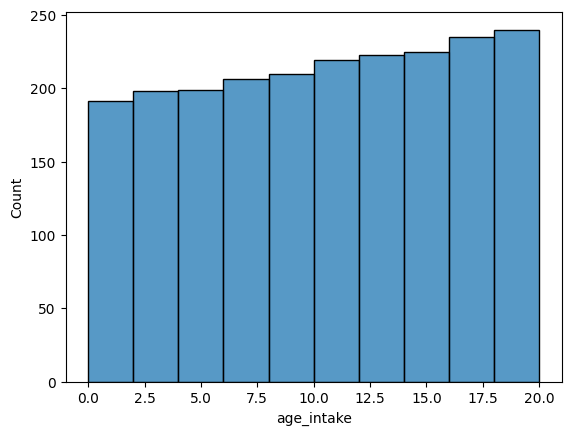

In [122]:
import seaborn as sns
sns.histplot(data = change_df["age_intake"], binwidth=2)

Observe, however, that aged, nursing, or pregnant dogs hardly have their outcome altered by having a name. Let's see what their predicted outcomes are:

In [123]:
nursing_condition = full_df[full_df["Intake Condition_Nursing"]==1]["predicts"].sum()/full_df.shape[0]
pregnant_condition = full_df[full_df["Intake Condition_Pregnant"]==1]["predicts"].sum()/full_df.shape[0]
aged_condition = full_df[full_df["Intake Condition_Aged"]==1]["predicts"].sum()/full_df.shape[0]
other_condition = full_df[full_df["Intake Condition_Other"]==1]["predicts"].sum()/full_df.shape[0]
print(f"Around {100*nursing_condition:.2f}% of all nursing animals are predicted to have a positive outcome")
print(f"Around {100*pregnant_condition:.2f}% of all pregnant animals are predicted to have a positive outcome")
print(f"Around {100*aged_condition:.2f}% of all aged animals are predicted to have a positive outcome")
print(f"Around {100*other_condition:.2f}% of all other-afflicted animals are predicted to have a positive outcome")


Around 9.15% of all nursing animals are predicted to have a positive outcome
Around 12.50% of all pregnant animals are predicted to have a positive outcome
Around 10.00% of all aged animals are predicted to have a positive outcome
Around 12.46% of all other-afflicted animals are predicted to have a positive outcome


Sadly, this paints a rather grim picture. Nursing, Pregnant, Aged, or Other-afflicted animals have hardly a good forecast for adoption, and as we saw above, this is not particularly affected by giving them a name either.
As a final, let's see how else we can make inference on this data. In particular, let's run a regression of all dummy-variables (and age) on the dummy that counts whether giving the synthetic animal a name would change their adoption outcome. This will show us which "comorbidities" have the biggest impact for making it less likely to be adopted if no name is given:

In [124]:

X_analysis = full_df.drop(["Name_nan", "predicts", "predicts_change", "change", "Intake Type_Owner Surrender", "Intake Condition_Normal", "Sex_Spayed Female", "Sex_Unknown"], axis = 1)
import statsmodels.api as sm 
X_analysis = sm.add_constant(X_analysis)

for a in X_analysis.columns:
    X_analysis[a] = pd.to_numeric(X_analysis[a])

y_analysis = full_df["change"]

So as not to fall in the dummy-trap, we set as a baseline-animal a owner-surrendered, spayed female cat.

In [125]:
from statsmodels.regression.linear_model import OLS


reg = OLS(endog = y_analysis, exog = X_analysis)



res = reg.fit()
print(res.summary())
print(f"A female spayed cat surrendered by its owner in normal condition has baseline probability of {100*res.params[0]:.2f}% of having its outcome status negatively impacted when unnamed")

                            OLS Regression Results                            
Dep. Variable:                 change   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     153.6
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        19:37:06   Log-Likelihood:                -2604.2
No. Observations:                4800   AIC:                             5238.
Df Residuals:                    4785   BIC:                             5336.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

We see the same picture here as we found in the data earlier: the baseline says that giving an owner-surrendered, spayed female kitten a name makes it roughly 30% more likely that she will face a positive outcome.
This pattern is hardly affected by age, but even stronger for stray animals, condition-"Other"-afflicted-animals, and sex-intact males and females alike. (Animals with Sex = Unknown were dropped for this purpose)
In contrast, being aged almost entirely negates the possibility of increasing an animal's adoption change by giving it a name, and this is about as strong for nursing animals and virtually impossible for pregnant animals. 

# 4 Conclusion

What can we learn from this project? Several things, I believe. First, we are able to predict very well based on just a few characteristics such as their sex, age, intake-types and -conditions, as well as whether they have a name, whether a given animal is going to get adopted. Any classifier consistently scored above 90% accuracy, with the voting-classifier among an SVM, KNN, and a Random-Forest performing arguably the best.
Next, we also saw using these predictions on synthetic data that giving an animal a name very much impacts their chances for getting adopted. This pattern was especially pronounced for stray animals, perhaps because they become more adorable and personalized that way. Sadly, it makes less of a difference for nursing, pregnant, or aged animals, all of which are predicted to face very bleak outcomes.
What can we learn from this? We have for sure not established any causality here: these shelters are all in Austin, TX, but they might, for example, be very heterogeneous. Some shelters might take excellent care of animals and therefore is able to provide most of them with a new home, whereas other shelters might not care about the animals and leaving them behind. If that correlates with whether or not the animal is shown to have a name (which I believe it does), the last results are hardly a causal effect of giving an animal a name. Rather, it might just represent overall favourable conditions.
But is it to be excluded that the name might have a bit of an impact? I do not think so. In particular, the cost of giving a nameless animal a name is virtually nil, and the effects, while overstated, are likely to be at least a little bit positive. Therefore, this, I believe, gives good evidence that providing sheltered cats and dogs with names will increase their likelihood of facing a positive outcome versus a negative one. 
Now if you'll excuse me, I have to look at the nearest shelter for aging, nursing, or pregnant animals, because my heart is breaking a little that nobody adopts them.